## Importación de Librerías

In [1]:
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


## Configuración del directorio del dataset

In [3]:
ORIGINAL_DATASET_PATH = r"D:\Downloads\DatasetFinal"  # Cambia esta ruta al dataset original
TEMP_DATASET_PATH = r"D:\Downloads\DatasetFinaltemp"    # Carpeta donde dividiremos los datos
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

# Proporciones para dividir
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15  # 15% validación
TEST_SPLIT = 0.15  # 15% prueba

## Función para dividir el dataset

In [5]:

# Función para dividir el dataset
def split_dataset(original_path, temp_path, train_split, val_split, test_split):
    if os.path.exists(temp_path):
        shutil.rmtree(temp_path)  # Eliminar si ya existe para evitar conflictos
    os.makedirs(temp_path)

    # Crear subcarpetas para train, val, y test
    train_path = os.path.join(temp_path, 'train')
    val_path = os.path.join(temp_path, 'val')
    test_path = os.path.join(temp_path, 'test')
    os.makedirs(train_path)
    os.makedirs(val_path)
    os.makedirs(test_path)

    for class_name in os.listdir(original_path):
        class_dir = os.path.join(original_path, class_name)
        if not os.path.isdir(class_dir):
            continue  # Ignorar si no es una carpeta
        # Listar todas las imágenes de la clase
        images = os.listdir(class_dir)
        train_images, temp_images = train_test_split(images, test_size=(1 - train_split), random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=test_split / (val_split + test_split), random_state=42)

        # Crear subcarpetas por clase
        os.makedirs(os.path.join(train_path, class_name))
        os.makedirs(os.path.join(val_path, class_name))
        os.makedirs(os.path.join(test_path, class_name))

        # Mover las imágenes a las carpetas respectivas
        for img in train_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(train_path, class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(val_path, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(test_path, class_name, img))

    return train_path, val_path, test_path

In [6]:
# Dividir el dataset
train_path, val_path, test_path = split_dataset(ORIGINAL_DATASET_PATH, TEMP_DATASET_PATH, TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT)

In [7]:

# Generadores de datos con aumento de datos para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Crear generadores
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3038 images belonging to 5 classes.
Found 652 images belonging to 5 classes.
Found 654 images belonging to 5 classes.


In [8]:
# Crear el modelo con MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelamos las capas base

# Construcción de la red
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Evita sobreajuste
x = Dense(128, activation='relu')(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compilación del modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Entrenamiento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 374ms/step - accuracy: 0.4697 - loss: 1.4039 - val_accuracy: 0.6549 - val_loss: 0.8644
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 364ms/step - accuracy: 0.6706 - loss: 0.9084 - val_accuracy: 0.7255 - val_loss: 0.7420
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 371ms/step - accuracy: 0.6970 - loss: 0.8469 - val_accuracy: 0.7224 - val_loss: 0.7398
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.7009 - loss: 0.7928 - val_accuracy: 0.7147 - val_loss: 0.7322
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.7372 - loss: 0.7230 - val_accuracy: 0.7025 - val_loss: 0.7636
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 380ms/step - accuracy: 0.7197 - loss: 0.7646 - val_accuracy: 0.7393 - val_loss: 0.7257
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 366ms/step - accuracy: 0.7432 - loss: 0.7161 - val_accuracy: 0.7515 - val_loss: 0.6866
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 366ms/step - accuracy: 0.7411 - loss: 0.7075 - val_accu

In [10]:

# Evaluación en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.7764 - loss: 0.6493
Test Loss: 0.6420799493789673, Test Accuracy: 0.7767584323883057


In [11]:
# Generar matriz de confusión y reporte de clasificación
test_gen.reset()
predictions = np.argmax(model.predict(test_gen), axis=1)
true_labels = test_gen.classes

print("Reporte de Clasificación en Prueba:")
print(classification_report(true_labels, predictions, target_names=list(train_gen.class_indices.keys())))

conf_matrix = confusion_matrix(true_labels, predictions)
print("Matriz de Confusión:")
print(conf_matrix)


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step
Reporte de Clasificación en Prueba:
               precision    recall  f1-score   support

high contrast       0.83      0.75      0.79        99
     high key       0.83      0.82      0.83       141
      low key       0.77      0.84      0.81       143
monochromatic       0.62      0.41      0.50        99
      vintage       0.77      0.91      0.84       172

     accuracy                           0.78       654
    macro avg       0.77      0.75      0.75       654
 weighted avg       0.77      0.78      0.77       654

Matriz de Confusión:
[[ 74   8   6   5   6]
 [  3 116   5   5  12]
 [  2   3 120   9   9]
 [  7  11  20  41  20]
 [  3   2   4   6 157]]


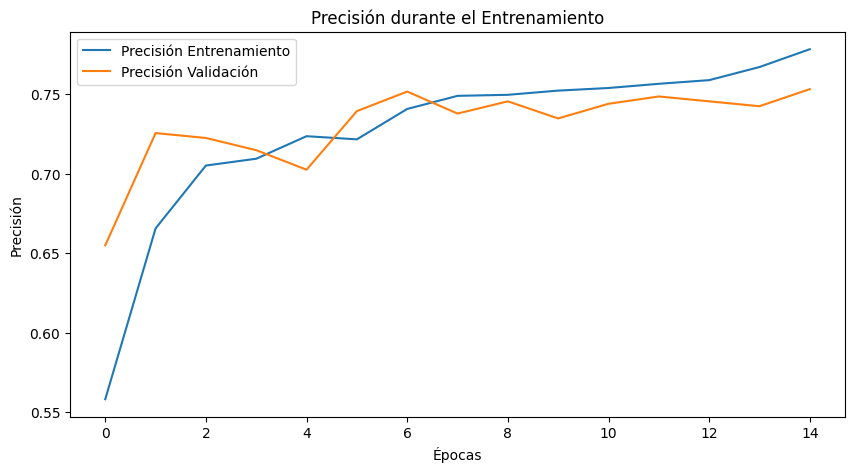

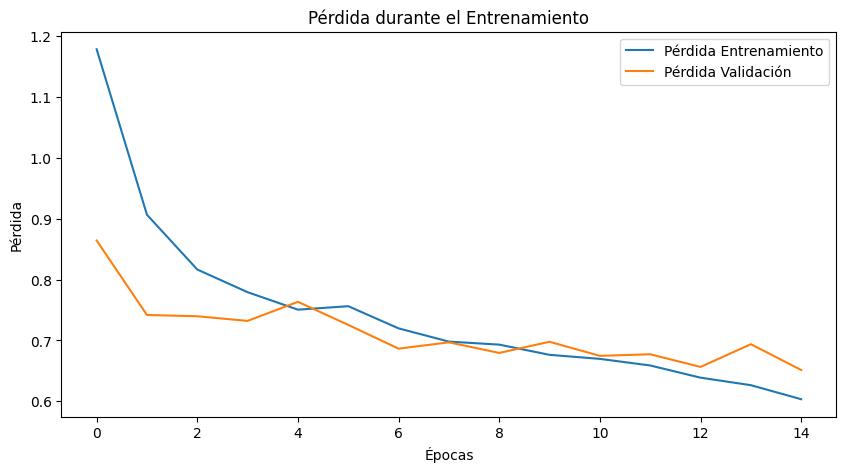

In [12]:
# Graficar desempeño
def plot_metrics(history):
    # Gráfico de precisión
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión Validación')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

    # Gráfico de pérdida
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida Validación')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

plot_metrics(history)


In [14]:

# Guardar el modelo
model.save("modelo_estilos_visuales_dividido.keras")
